In [15]:
import numpy as np
import pandas as pd
import yfinance as yf
from ta import momentum, trend

import time
import copy
import numpy as np
import pandas as pd
import chainer
import chainer.functions as F
import chainer.links as L
from plotly import tools
from plotly.graph_objs import *
from plotly.offline import init_notebook_mode, iplot, iplot_mpl


from tqdm import tqdm

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

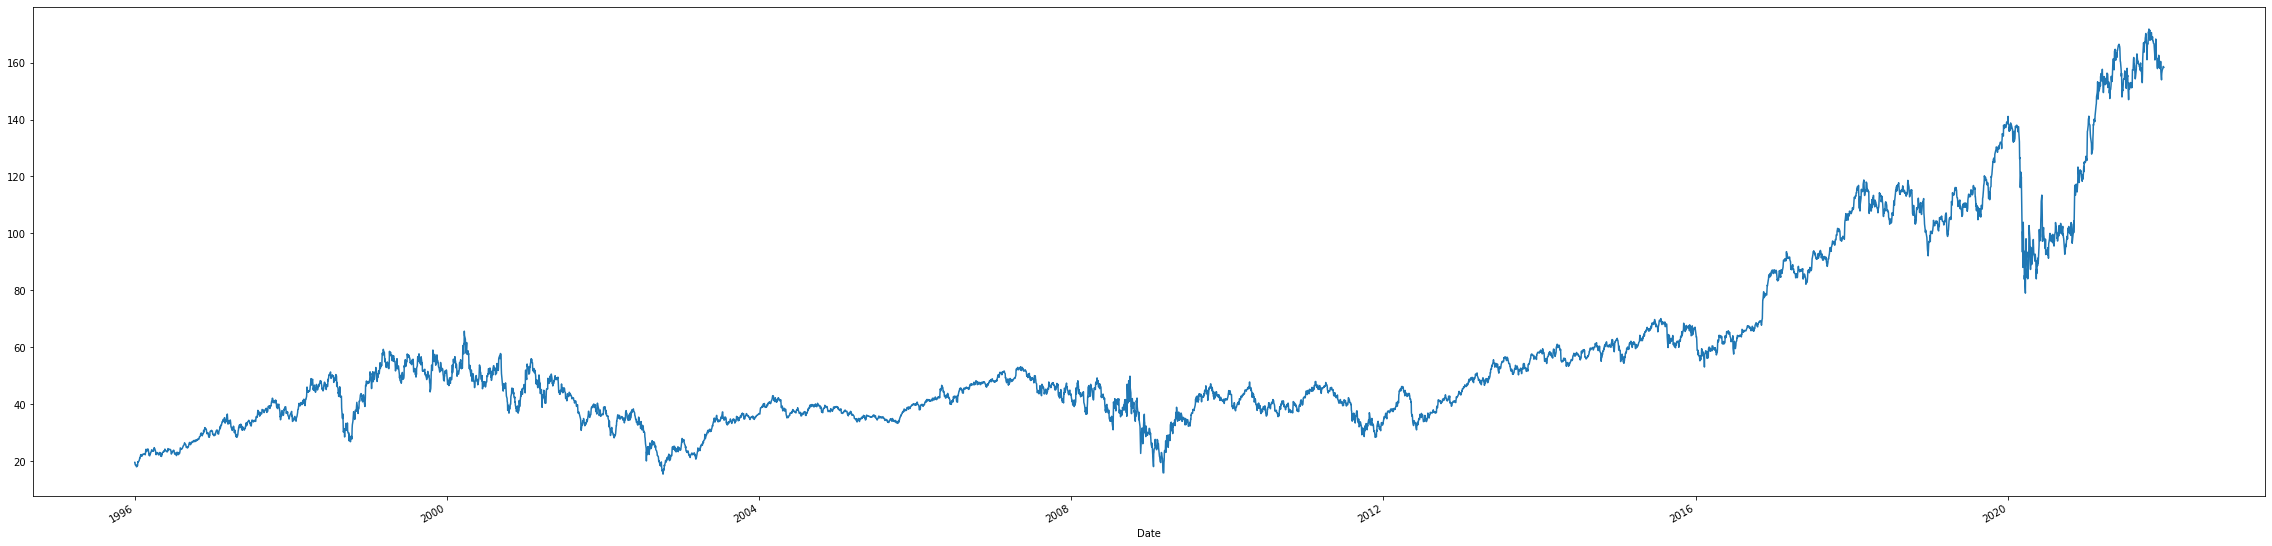

In [57]:
start_date = '1996-01-01'
end_date = '2022-01-01'

ticker = 'JPM'

data = yf.download(ticker, start_date, end_date)

data['Close'].plot(figsize = (40,10))

In [58]:
rsi_period = 14
data['RSI'] = momentum.RSIIndicator(data['Close'], rsi_period).rsi()

ema_period = 50
data['EMA'] = trend.EMAIndicator(data['Close'], window=ema_period).ema_indicator()

data['Close_EMA_ratio'] = data['Close']/data['EMA']

data = data[50:]
data.head()

,Open,High,Low,Close,Adj Close,Volume,RSI,EMA,Close_EMA_ratio
Date,,,,,,,,,
1996-03-13,22.250000,22.416668,22.000000,22.250000,10.177775,5394900,45.357739,21.974400,1.012542
1996-03-14,22.458332,23.166668,22.458332,22.750000,10.406488,5643000,51.263575,22.004816,1.033865
1996-03-15,22.666668,22.750000,22.500000,22.625000,10.349312,4398900,49.814038,22.029137,1.027049
1996-03-18,22.750000,23.375000,22.750000,23.250000,10.635204,4755900,56.445483,22.077014,1.053132
1996-03-19,23.416668,23.541668,23.125000,23.291668,10.654263,5008500,56.854805,22.124647,1.052748


In [59]:
split_len = int(0.8 * len(data[50:]))

train = data[13:split_len]
test = data[split_len:]

train.shape, test.shape

((5144, 9), (1340, 9))

In [133]:
class Environment:
    
    def __init__(self, data, history_t=50):
        self.data = data
        self.history_t = history_t
        self.reset()
        
    def reset(self):
        self.t = 0
        self.done = False
        self.profits = 0
        self.positions = []
        self.capital = 10000
        self.position_value = 0
        self.rsi = 50
        self.cema = 1
        self.history = [0 for _ in range(self.history_t)]
        return [self.position_value] + [self.capital] + [self.rsi] + [self.cema] + self.history # obs
    
    def step(self, act):
        reward = -1
        
        # act = 0: stay, 1: buy, 2: sell
        if act == 1:
            if self.capital - self.data.iloc[self.t, :]['Close'] < 0:
                reward = -100
            else:
                self.positions.append(self.data.iloc[self.t, :]['Close'])
                self.capital -= self.data.iloc[self.t, :]['Close']
                reward = 2
        elif act == 2: # sell
            if len(self.positions) == 0:
                reward = -100
            else:
                profits = 0
                for p in self.positions:
                    profits += (self.data.iloc[self.t, :]['Close'] - p)
                reward += profits
                self.profits += profits
                self.positions = []
                self.capital += self.data.iloc[self.t, :]['Close']
        
        # set next time
        self.t += 1
        self.position_value = 0
        for p in self.positions:
            self.position_value += (self.data.iloc[self.t, :]['Close'] - p)
        self.history.pop(0)
        self.history.append(self.data.iloc[self.t, :]['Close'] - self.data.iloc[(self.t-1), :]['Close'])
        
        
        # clipping reward
        # if reward > 0:
        #     reward = 1
        # elif reward < 0:
        #     reward = -1
        
        return [self.position_value] + [self.capital] + [self.data['RSI'][self.t]] + [self.data['Close_EMA_ratio'][self.t]] + self.history, reward, self.done # obs, reward, done

In [136]:
def train_dqn(env):

    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc21 = L.Linear(hidden_size, hidden_size),
                fc22 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, output_size)
            )

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            h = F.relu(self.fc21(h))
            h = F.relu(self.fc22(h))
            y = self.fc3(h)
            return y

        def reset(self):
            self.zerograds()

    Q = Q_Network(input_size=env.history_t+4, hidden_size=100, output_size=3)
    Q_ast = copy.deepcopy(Q)
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(Q)

    epoch_num = 100
    step_max = len(env.data)-1
    memory_size = 200
    batch_size = 20
    epsilon = 1.0
    epsilon_decrease = 1e-6
    epsilon_min = 0.15
    start_reduce_epsilon = 200000
    train_freq = 100
    update_q_freq = 200
    gamma = 0.97
    show_log_freq = 10

    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []
    total_capital = []

    start = time.time()
    for epoch in tqdm(range(epoch_num), desc="Training", unit="epoch"):

        pobs = env.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0

        for step in range(step_max):

            # select act
            pact = np.random.randint(3)
            if np.random.rand() > epsilon:
                pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
                pact = np.argmax(pact.data)

            # act
            obs, reward, done = env.step(pact)

                   

            # add memory
            memory.append((pobs, pact, reward, obs, done))
            if len(memory) > memory_size:
                memory.pop(0)

            # train or update q
            if len(memory) == memory_size:
                if total_step % train_freq == 0:
                    shuffled_memory = np.random.permutation(memory)
                    memory_idx = range(len(shuffled_memory))
                    for i in memory_idx[::batch_size]:
                        batch = np.array(shuffled_memory[i:i+batch_size])
                        b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                        b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                        b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                        q = Q(b_pobs)
                        maxq = np.max(Q_ast(b_obs).data, axis=1)
                        target = copy.deepcopy(q.data)
                        for j in range(batch_size):
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                        Q.reset()
                        loss = F.mean_squared_error(q, target)
                        total_loss += loss.data
                        loss.backward()
                        optimizer.update()

                if total_step % update_q_freq == 0:
                    Q_ast = copy.deepcopy(Q)

            # epsilon
            if epsilon > epsilon_min:
                epsilon = 1-0.02*epoch

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)
        total_capital.append(env.capital)

        if (epoch+1) % show_log_freq == 0:
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            elapsed_time = time.time()-start
            print('\n'.join(map(str, [
                "Epoch: " + str(epoch + 1),
                "Epsilon: " + str(epsilon),
                "Total Steps: " + str(total_step),
                "Reward: " + str(log_reward),
                "Loss: " + str(log_loss),
                "Current Capital: " + str(env.capital),
                "Time Elapsed: " + str(elapsed_time),
            ])))
            start = time.time()
            
    return Q, total_losses, total_rewards

In [137]:
Q, total_losses, total_rewards = train_dqn(Environment(train))

Training:   0%|          | 0/100 [00:00<?, ?epoch/s]/var/folders/yf/zxptpvps4wd81trf6xv52k_40000gn/T/ipykernel_22231/962704725.py:79: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

/var/folders/yf/zxptpvps4wd81trf6xv52k_40000gn/T/ipykernel_22231/962704725.py:87: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

Training:  10%|█         | 10/100 [00:25<04:10,  2.78s/epoch]

Epoch: 10
Epsilon: 0.8200000000000001
Total Steps: 51430
Reward: -207561.49051942825
Loss: 6383489.3414097605
Current Capital: 36.30294895172119
Time Elapsed: 25.53298282623291


Training:  20%|██        | 20/100 [00:58<04:28,  3.36s/epoch]

Epoch: 20
Epsilon: 0.62
Total Steps: 102860
Reward: -176876.98403396606
Loss: 82648.21722365617
Current Capital: 57.13336181640625
Time Elapsed: 32.56781220436096


Training:  30%|███       | 30/100 [01:37<04:47,  4.11s/epoch]

Epoch: 30
Epsilon: 0.42000000000000004
Total Steps: 154290
Reward: -118940.02373695374
Loss: 55219.23637825474
Current Capital: 64.94732093811035
Time Elapsed: 39.0328631401062


Training:  40%|████      | 40/100 [02:23<04:45,  4.76s/epoch]

Epoch: 40
Epsilon: 0.21999999999999997
Total Steps: 205720
Reward: -73546.20564470292
Loss: 31166.706624270977
Current Capital: 77.75996208190918
Time Elapsed: 46.10579514503479


Training:  50%|█████     | 50/100 [03:15<04:23,  5.28s/epoch]

Epoch: 50
Epsilon: 0.14
Total Steps: 257150
Reward: -41880.50433940887
Loss: 42043.94400863871
Current Capital: 46.927066802978516
Time Elapsed: 51.92585802078247


Training:  60%|██████    | 60/100 [04:08<03:33,  5.33s/epoch]

Epoch: 60
Epsilon: 0.14
Total Steps: 308580
Reward: -34522.70384626389
Loss: 17854.511443284526
Current Capital: 2.397958755493164
Time Elapsed: 52.89509105682373


Training:  70%|███████   | 70/100 [05:00<02:36,  5.23s/epoch]

Epoch: 70
Epsilon: 0.14
Total Steps: 360010
Reward: -38470.89320287704
Loss: 21991.229529006407
Current Capital: 19.545616149902344
Time Elapsed: 52.86378526687622


Training:  80%|████████  | 80/100 [05:53<01:46,  5.31s/epoch]

Epoch: 80
Epsilon: 0.14
Total Steps: 411440
Reward: -42526.29850559235
Loss: 18434.443144422585
Current Capital: 27.332470893859863
Time Elapsed: 52.141571044921875


Training:  90%|█████████ | 90/100 [06:43<00:50,  5.01s/epoch]

Epoch: 90
Epsilon: 0.14
Total Steps: 462870
Reward: -40828.951826667784
Loss: 18316.680127001928
Current Capital: 25.028352737426758
Time Elapsed: 50.84588408470154


Training: 100%|██████████| 100/100 [07:35<00:00,  4.56s/epoch]

Epoch: 100
Epsilon: 0.14
Total Steps: 514300
Reward: -39519.986831760405
Loss: 30108.141561142354
Current Capital: 33.543325424194336
Time Elapsed: 52.01196575164795


In [138]:
def plot_loss_reward(total_losses, total_rewards):

    figure = tools.make_subplots(rows=1, cols=2, subplot_titles=('loss', 'reward'), print_grid=False)
    figure.append_trace(Scatter(y=total_losses, mode='lines', line=dict(color='skyblue')), 1, 1)
    figure.append_trace(Scatter(y=total_rewards, mode='lines', line=dict(color='orange')), 1, 2)
    figure['layout']['xaxis1'].update(title='epoch')
    figure['layout']['xaxis2'].update(title='epoch')
    figure['layout'].update(height=600, width=1200, showlegend=False)
    iplot(figure)

plot_loss_reward(total_losses, total_rewards)

/Users/celestiq/tensorflow-ml/ml_env/lib/python3.8/site-packages/plotly/tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [139]:
def plot_train_test_by_q(train_env, test_env, Q, algorithm_name):
    
    # train
    pobs = train_env.reset()
    train_acts = []
    train_rewards = []

    for i in range(len(train_env.data)-1):
        # print(i)
        pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
        pact = np.argmax(pact.data)
        train_acts.append(pact)
            
        obs, reward, done = train_env.step(pact)
        train_rewards.append(reward)

        pobs = obs
        
    train_profits = train_env.profits
    
    # print("Testing Data")
    # test
    pobs = test_env.reset()
    test_acts = []
    test_rewards = []

    for _ in range(len(test_env.data)-1):
    
        pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
        pact = np.argmax(pact.data)
        test_acts.append(pact)
            
        obs, reward, done = test_env.step(pact)
        test_rewards.append(reward)

        pobs = obs
        
    test_profits = test_env.profits
    
    # plot
    train_copy = train_env.data.copy()
    test_copy = test_env.data.copy()
    train_copy['act'] = train_acts + [np.nan]
    train_copy['reward'] = train_rewards + [np.nan]
    test_copy['act'] = test_acts + [np.nan]
    test_copy['reward'] = test_rewards + [np.nan]
    train0 = train_copy[train_copy['act'] == 0]
    train1 = train_copy[train_copy['act'] == 1]
    train2 = train_copy[train_copy['act'] == 2]
    test0 = test_copy[test_copy['act'] == 0]
    test1 = test_copy[test_copy['act'] == 1]
    test2 = test_copy[test_copy['act'] == 2]
    act_color0, act_color1, act_color2 = 'black', 'green', 'red'

    data1 = [
        Candlestick(x=train0.index, open=train0['Open'], high=train0['High'], low=train0['Low'], close=train0['Close'], increasing=dict(line=dict(color=act_color0)), decreasing=dict(line=dict(color=act_color0))),
        Candlestick(x=train1.index, open=train1['Open'], high=train1['High'], low=train1['Low'], close=train1['Close'], increasing=dict(line=dict(color=act_color1)), decreasing=dict(line=dict(color=act_color1))),
        Candlestick(x=train2.index, open=train2['Open'], high=train2['High'], low=train2['Low'], close=train2['Close'], increasing=dict(line=dict(color=act_color2)), decreasing=dict(line=dict(color=act_color2))),
        Candlestick(x=test0.index, open=test0['Open'], high=test0['High'], low=test0['Low'], close=test0['Close'], increasing=dict(line=dict(color=act_color0)), decreasing=dict(line=dict(color=act_color0))),
        Candlestick(x=test1.index, open=test1['Open'], high=test1['High'], low=test1['Low'], close=test1['Close'], increasing=dict(line=dict(color=act_color1)), decreasing=dict(line=dict(color=act_color1))),
        Candlestick(x=test2.index, open=test2['Open'], high=test2['High'], low=test2['Low'], close=test2['Close'], increasing=dict(line=dict(color=act_color2)), decreasing=dict(line=dict(color=act_color2)))
    ]
    title = '{}: train s-reward {}, profits {}, test s-reward {}, profits {}'.format(
        algorithm_name,
        int(sum(train_rewards)),
        int(train_profits),
        int(sum(test_rewards)),
        int(test_profits)
    )
    layout = {
        'title': title,
        'showlegend': False,
         'shapes': [
             {'x0': 6000, 'x1': 6000, 'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper', 'line': {'color': 'rgb(0,0,0)', 'width': 1}}
         ],
        'annotations': [
            {'x': 6000, 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 'xanchor': 'left', 'text': ' test data'},
            {'x': 6000, 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 'xanchor': 'right', 'text': 'train data '}
        ]
    }
    figure = Figure(data=data1, layout=layout)
    iplot(figure)
    return train_acts, test_acts, train_profits, test_profits

    

train_acts, test_acts, train_profits, test_profits = plot_train_test_by_q(Environment(train), Environment(test), Q, 'DQN')